## PFG Bank: Credit Card Design

* Team-lead GitLab userid: dbeaudreau
* Group name: Team Nine From Outer Space
* Team member names: Chenxuan Liu, Danielle Beaudreau, Nicholas Feldman, Wan-Ting Hsu, Yijie Shi

## Setup

Please complete this Jupyter notebook by answering the questions in `pfg-bank.pdf` on Canvas (week10/). Create a Notebook and HTML file with all your results and comments and push both the Notebook and HTML file to GitLab when your team is done. All results MUST be reproducible (i.e., the TA and I must be able to recreate the HTML from the Jupyter Notebook file without changes or errors). This means that you should NOT use any python-packages that are not part of the rsm-msba-spark docker container.

This is the final group assignment for MGTA 455 and you will be using git and GitLab. If two people edit the same file at the same time you could get what is called a "merge conflict". git will not decide for you who's change to accept so the team-lead will have to determine which edits to use. To avoid merge conflicts, **always** "pull" changes to the repo before you start working on any files. Then, when you are done, save and commit your changes, and push them to GitLab. Make "pull first" a habit!

In [1]:
import os

import numpy as np
import pandas as pd
import pyrsm as rsm
import statsmodels.formula.api as smf
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit
import rpy2

## Question answers

1.	CLV varies by BK score because it is an estimation of the risk of bankruptcy for a given individual.  As the score rises the predicted risk of bankruptcy rises.  Therefore customers with higher scores have a lower CLV, holding all else constant because we have to account for the fact that have a greater predicted risk of bankruptcy and thus default on all or part of their debts to all their creditors which would include us if we issued them a card. Thus some of the predicted revenue is discounted by PFG Bank’s models to reflect potential losses similar to discounting future earns to reflect the fact that future dollars are less valuable than current dollars as well as the potential to use those dollars could have been put to if we had them presently. Different products have different CLVs because they produce different amount of revenues.  Having a lower APR or not having an annual fee reduces the amount of revenue taken in by PFG Bank holding all else constant. PFG Bank has provided their estimates of CLVs so we are using them in our analysis.

2.  The historical data is useful as a starting point for analysis. Although it is definitely not data from a random experiment and although it is not balanced between all products and BK Scores for customers, it does provide information about the response rates of the various groups of customers to the various products that will consider offering. When combined with other data this will help us to design experiments and create a plan to deploy. However, after major competitors launched their campaigns, customer behavior will inevitably change, so historical data becomes less accurate to reflect the current situation.

3.  Whether there is a best product for all customers depends on how we define best. If the only measurement is response rate, then all groups, at least according to the historical data, prefer a card with no annual fee, lower APR (14.9 is the lowest we have data for but logic would suggest even lower would be even more preferred) and a fixed rate.  However, when we take into account the different CLVs, different groups have different profit-maximizing products.  Importantly this is historical data, customers may have different preferences currently than earlier. In fact we have good knowledge from PFG Bank that customers are even more adverse to annual fees and that falling interest rates cause customers to be more receptive to variable rates. The first only reinforces desirability of no fee cards while the other might cause variable rate response rates to gain relative to fix rate response rates when compared to historical data.

4. Although from an academic or intellectual curiosity viewpoint the correct thing to do would be for us to run a full factorial trial of the possible credit card options, we have decided that this is not the correct course of action. With limited knowledge on variable interactions, especially when historical data is itself imbalanced, it is ill-advised to perform a partial factorial design even if the d-efficiency score is high. As data scientists we are quite interested in what actual demand for the various groups will be for each of the different possible offers, however, as business analysts, knowledge for its own sake is perhaps unfortunately not our goal, our instructions were to maximize profits; expenses from any experimentation we perform count against this goal so experimentation in this case is only worth it if the knowledge we gain from it pays off enough that it outweighs these expenses.

Given this, we decided that given the historical data and information we learned from PFG Bank about industry trends to only test four options likely to have high overall profit. As cards with an annual fee is undesirable for all groups, we have decided to only design products with a 0 fee. Using historical data, we have developed a logistic regression model that provides some insight regarding which card options are likely to be the best for each bankruptcy score group. 

It is determined that, for both bankruptcy scores 150 and 200, the best two options are 14.9% annual rate with 0 annual fee, with either fixed or variable rate. This makes intuitive sense as they have probably received the best options from our competitors, so we are only offering the best options to entice them. For bankruptcy score 250, while the most appealing option according to historical data is 19.8% fixed rate with 0 fees, the increase in popularity for variable rates has led to the decision that we will be testing two cards for this group as well: 0 annual fee with variable rates, either at 16.8% or 19.8%. 

For all groups, we have decided to send out 4000 test mailings for the first wave. For each group, we determine the better option out of the two tested to send to the rest of the customer base.

The best credit card option for each group is as follows:
150: 14.9% variable, 0 annual fee
200: 14.9% variable, 0 annual fee
250: 19.8% variable, 0 annual fee

The first wave resulted in a profit of $10,320, the second wave $876,206, and total $886,526.


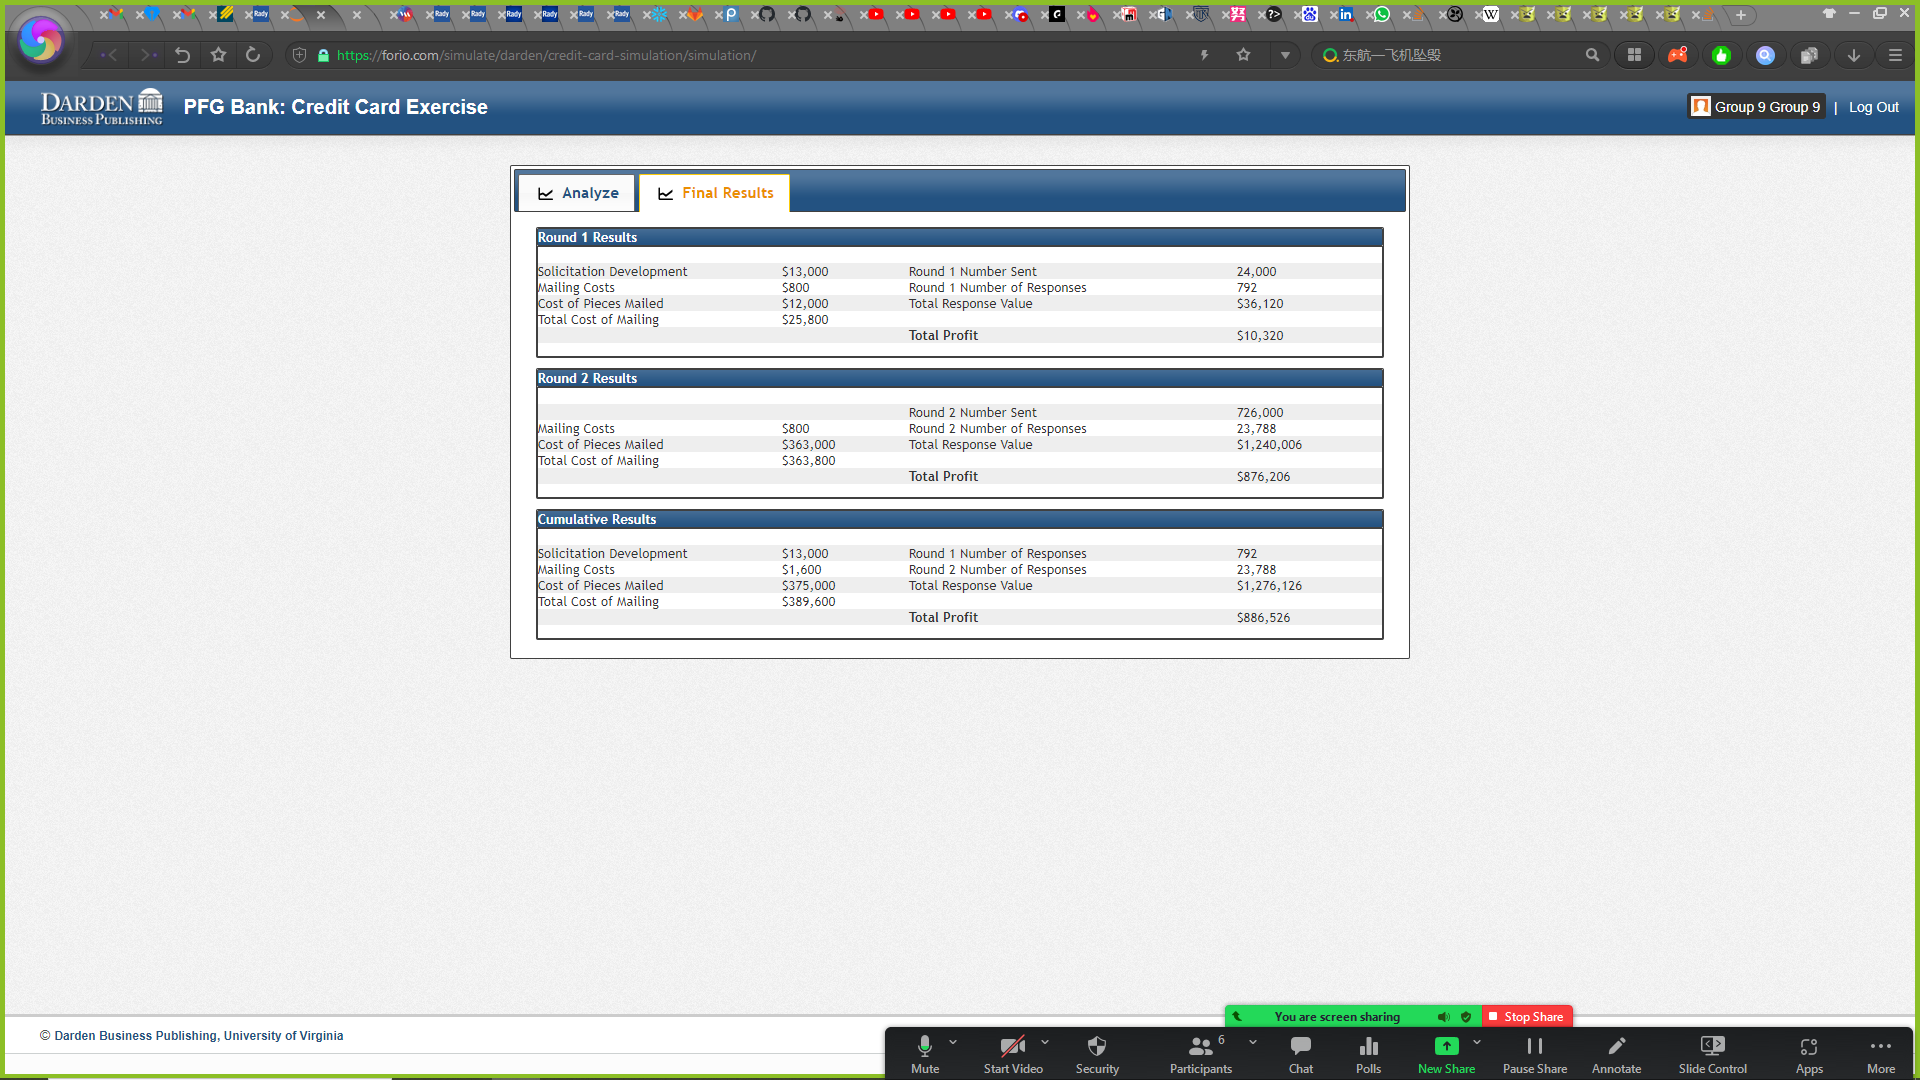

In [2]:
from IPython.display import Image, display
display(Image(filename='images/pfg_bank.png'))

In [3]:
%reload_ext rpy2.ipython

In [4]:
%%R

result <- radiant.design::doe(
  factors = c(
    "apr; 14.9; 16.8; 19.8", 
    "fixed_var; fixed; variable", 
    "annual_fee; 0; 20", 
    "bk_score; 150; 200; 250"
  ), 
  trials = 18, 
  seed = 1234
)
summary(result, eff = TRUE, part = TRUE, full = TRUE)

Experimental design
# trials for partial factorial: 18 
# trials for full factorial   : 36 
Random seed                   : 1234 

Attributes and levels:
apr: 14.9, 16.8, 19.8 
fixed_var: fixed, variable 
annual_fee: 0, 20 
bk_score: 150, 200, 250 

Design efficiency:
 Trials D-efficiency Balanced
     18        0.965     TRUE

Partial factorial design correlations:
** Note: Variables are assumed to be ordinal **
           apr fixed_var annual_fee bk_score
apr          1     0.000      0.000        0
fixed_var    0     1.000      0.174        0
annual_fee   0     0.174      1.000        0
bk_score     0     0.000      0.000        1

Partial factorial design:
 trial  apr fixed_var annual_fee bk_score
     1 14.9     fixed          0      150
     2 14.9     fixed          0      200
     3 14.9     fixed          0      250
    10 14.9  variable         20      150
    11 14.9  variable         20      200
    12 14.9  variable         20      250
    14 16.8     fixed          0     

In [5]:
dtype = {
    'apr':'category',
    'fixed_var':'category',
    'annual_fee':'category',
    'bk_score':'category'
}

data = pd.read_excel('data/exhibits.xls',
                     sheet_name = 'exhibit1',
                     dtype = dtype)

data

,date,apr,fixed_var,annual_fee,visamc,nr_mailed,non_resp,resp,bk_score,average_bk
0,April,16.8,Fixed,20,MC,167000,165467,1533,200,210
1,April,16.8,Fixed,0,MC,81000,78104,2896,200,210
2,April,19.8,Fixed,20,MC,143000,142410,590,200,210
3,April,19.8,Fixed,0,MC,100000,97948,2052,200,210
4,September,14.9,Fixed,20,Visa,177000,172671,4329,250,255
5,September,14.9,Variable,20,Visa,170000,166996,3004,250,255
6,September,16.8,Fixed,20,Visa,255000,252017,2983,250,255
7,September,19.8,Fixed,20,Visa,35000,34825,175,250,255
8,September,16.8,Fixed,0,Visa,65000,62484,2516,250,255
9,September,19.8,Fixed,0,Visa,95000,92885,2115,250,255


In [6]:
data_melt = pd.melt(data,
                    id_vars = ['date',
                               'apr',
                               'fixed_var',
                               'annual_fee',
                               'visamc',
                               'nr_mailed',
                               'bk_score',
                               'average_bk'],
                    value_vars = ['non_resp',
                                  'resp'],
                    var_name = 'resp',
                    value_name = 'freq')

data_melt['resp_yes'] = rsm.ifelse(data_melt.resp == 'resp', 1, 0)
data_melt

,date,apr,fixed_var,annual_fee,visamc,nr_mailed,bk_score,average_bk,resp,freq,resp_yes
0,April,16.8,Fixed,20,MC,167000,200,210,non_resp,165467,0
1,April,16.8,Fixed,0,MC,81000,200,210,non_resp,78104,0
2,April,19.8,Fixed,20,MC,143000,200,210,non_resp,142410,0
3,April,19.8,Fixed,0,MC,100000,200,210,non_resp,97948,0
4,September,14.9,Fixed,20,Visa,177000,250,255,non_resp,172671,0
5,September,14.9,Variable,20,Visa,170000,250,255,non_resp,166996,0
6,September,16.8,Fixed,20,Visa,255000,250,255,non_resp,252017,0
7,September,19.8,Fixed,20,Visa,35000,250,255,non_resp,34825,0
8,September,16.8,Fixed,0,Visa,65000,250,255,non_resp,62484,0
9,September,19.8,Fixed,0,Visa,95000,250,255,non_resp,92885,0


In [7]:
formula = 'resp_yes ~ apr + fixed_var + annual_fee + bk_score'

lr = smf.glm(formula = formula,
             family = Binomial(link = logit()),
             data = data_melt,
             freq_weights = data_melt.freq).fit()
print(rsm.or_ci(lr))
print(rsm.model_fit(lr))

                   index     OR     OR%   2.5%  97.5% p.values     
1            apr[T.16.8]  0.471  -52.9%  0.454  0.489   < .001  ***
2            apr[T.19.8]  0.257  -74.3%  0.245  0.269   < .001  ***
3  fixed_var[T.Variable]  0.741  -25.9%  0.711  0.772   < .001  ***
4       annual_fee[T.20]  0.290  -71.0%  0.281  0.298   < .001  ***
5        bk_score[T.200]  1.232   23.2%  1.174  1.293   < .001  ***
6        bk_score[T.250]  1.425   42.5%  1.372  1.480   < .001  ***

Pseudo R-squared (McFadden): 0.033
Pseudo R-squared (McFadden adjusted): 0.033
Area under the RO Curve (AUC): 0.5
Log-likelihood: -132938.55, AIC: 265891.101, BIC: 265976.74
Chi-squared: 1494898.535 df(6), p.value < 0.001 
Nr obs: 28

None


In [8]:
dct = rsm.levels_list(data_melt[['apr',
                                 'fixed_var',
                                 'annual_fee',
                                 'bk_score']])
dct

{'apr': [16.8, 19.8, 14.9],
 'fixed_var': ['Fixed', 'Variable'],
 'annual_fee': [20, 0],
 'bk_score': [200, 250, 150]}

In [9]:
expand = rsm.expand_grid(dct)

cat = ['apr','fixed_var','annual_fee','bk_score']
for c in cat:
    expand[c] = expand[c].astype('category')

expand['pred'] = lr.predict(expand)

In [10]:
clv_val = pd.read_excel('data/exhibits.xls',
                        sheet_name = 'exhibit2')
clv_val

,offer,apr,fixed_var,annual_fee,clv150,clv200,clv250
0,1,14.9,Fixed,20,83,63,33
1,2,14.9,Variable,20,93,73,43
2,3,14.9,Fixed,0,52,32,2
3,4,14.9,Variable,0,62,42,12
4,5,16.8,Fixed,20,103,83,53
5,6,16.8,Variable,20,113,93,63
6,7,16.8,Fixed,0,72,52,22
7,8,16.8,Variable,0,82,62,32
8,9,19.8,Fixed,20,131,111,81
9,10,19.8,Variable,20,141,121,91


In [11]:
clv_melt = pd.melt(clv_val,
                   id_vars = ['offer',
                              'apr',
                              'fixed_var',
                              'annual_fee'],
                   value_vars = ['clv150',
                                 'clv200',
                                 'clv250'],
                   var_name = 'bk_score',
                   value_name = 'clv')
clv_melt['bk_score'] = clv_melt['bk_score'].str[3:].astype(int)

for c in cat:
    clv_melt[c] = clv_melt[c].astype('category')

In [12]:
combined = expand.merge(clv_melt, on = ['apr','fixed_var','annual_fee','bk_score'])
combined['exp'] = combined.pred * combined.clv
combined

,apr,fixed_var,annual_fee,bk_score,pred,offer,clv,exp
0,16.8,Fixed,20,200,0.010029,5,83,0.832433
1,16.8,Fixed,20,250,0.011581,5,53,0.613799
2,16.8,Fixed,20,150,0.008156,5,103,0.840040
3,16.8,Fixed,0,200,0.033799,7,52,1.757529
4,16.8,Fixed,0,250,0.038884,7,22,0.855442
5,16.8,Fixed,0,150,0.027609,7,72,1.987813
6,16.8,Variable,20,200,0.007448,6,93,0.692698
7,16.8,Variable,20,250,0.008604,6,63,0.542070
8,16.8,Variable,20,150,0.006054,6,113,0.684100
9,16.8,Variable,0,200,0.025257,8,62,1.565929


In [13]:
combined[(combined.bk_score == 150)].sort_values('exp', ascending = False)

,apr,fixed_var,annual_fee,bk_score,pred,offer,clv,exp
29,14.9,Fixed,0,150,0.056822,3,52,2.954727
35,14.9,Variable,0,150,0.042719,4,62,2.648562
5,16.8,Fixed,0,150,0.027609,7,72,1.987813
11,16.8,Variable,0,150,0.020598,8,82,1.689023
17,19.8,Fixed,0,150,0.015252,11,100,1.525182
26,14.9,Fixed,20,150,0.017148,1,83,1.423324
23,19.8,Variable,0,150,0.011342,12,110,1.247653
32,14.9,Variable,20,150,0.012759,2,93,1.186595
2,16.8,Fixed,20,150,0.008156,5,103,0.840040
8,16.8,Variable,20,150,0.006054,6,113,0.684100


In [14]:
combined[(combined.bk_score == 200)].sort_values('exp', ascending = False)

,apr,fixed_var,annual_fee,bk_score,pred,offer,clv,exp
27,14.9,Fixed,0,200,0.069096,3,32,2.211081
33,14.9,Variable,0,200,0.052115,4,42,2.188838
3,16.8,Fixed,0,200,0.033799,7,52,1.757529
9,16.8,Variable,0,200,0.025257,8,62,1.565929
15,19.8,Fixed,0,200,0.018725,11,80,1.497984
24,14.9,Fixed,20,200,0.021044,1,63,1.325779
21,19.8,Variable,0,200,0.013938,12,90,1.254388
30,14.9,Variable,20,200,0.015673,2,73,1.144164
0,16.8,Fixed,20,200,0.010029,5,83,0.832433
6,16.8,Variable,20,200,0.007448,6,93,0.692698


In [15]:
combined[(combined.bk_score == 250)].sort_values('exp', ascending = False)

,apr,fixed_var,annual_fee,bk_score,pred,offer,clv,exp
16,19.8,Fixed,0,250,0.021593,11,50,1.079634
22,19.8,Variable,0,250,0.016084,12,60,0.965060
10,16.8,Variable,0,250,0.029096,8,32,0.931059
4,16.8,Fixed,0,250,0.038884,7,22,0.855442
25,14.9,Fixed,20,250,0.024258,1,33,0.800528
31,14.9,Variable,20,250,0.018083,2,43,0.777553
34,14.9,Variable,0,250,0.059786,4,12,0.717426
1,16.8,Fixed,20,250,0.011581,5,53,0.613799
7,16.8,Variable,20,250,0.008604,6,63,0.542070
13,19.8,Fixed,20,250,0.006351,9,81,0.514425


In [16]:
round_1 = pd.read_csv('data/round_1.csv')
round_1 = round_1.merge(combined, on = ['offer', 'bk_score'])
result_1 = round_1.loc[round_1.Sent != 0,:]
result_1

,offer,bk_score,Sent,Responses,apr,fixed_var,annual_fee,pred,clv,exp
2,3,150,4000,156,14.9,Fixed,0,0.056822,52,2.954727
3,4,150,4000,144,14.9,Variable,0,0.042719,62,2.648562
14,3,200,4000,187,14.9,Fixed,0,0.069096,32,2.211081
15,4,200,4000,160,14.9,Variable,0,0.052115,42,2.188838
31,8,250,4000,83,16.8,Variable,0,0.029096,32,0.931059
35,12,250,4000,62,19.8,Variable,0,0.016084,60,0.965060


In [17]:
import warnings
warnings.filterwarnings("ignore")

result_1['resp_actual'] = result_1.Responses / result_1.Sent
result_1['exp_actual'] = result_1.resp_actual * result_1.clv
result_1 = result_1.reset_index()
result_1

,index,offer,bk_score,Sent,Responses,apr,fixed_var,annual_fee,pred,clv,exp,resp_actual,exp_actual
0,2,3,150,4000,156,14.9,Fixed,0,0.056822,52,2.954727,0.03900,2.028
1,3,4,150,4000,144,14.9,Variable,0,0.042719,62,2.648562,0.03600,2.232
2,14,3,200,4000,187,14.9,Fixed,0,0.069096,32,2.211081,0.04675,1.496
3,15,4,200,4000,160,14.9,Variable,0,0.052115,42,2.188838,0.04000,1.680
4,31,8,250,4000,83,16.8,Variable,0,0.029096,32,0.931059,0.02075,0.664
5,35,12,250,4000,62,19.8,Variable,0,0.016084,60,0.965060,0.01550,0.930


In [18]:
soli = 10000 + 3 * 1000
mail = 800
wave_1 = 0.5 * 6 * 4000
total_cost_1 = wave_1 + mail + soli
total_cost_1

25800.0

In [19]:
rev_1 = result_1.exp_actual.sum() * 4000
rev_1

36120.0

In [20]:
prof_1 = rev_1 - total_cost_1
prof_1

10320.0

In [21]:
round_2 = pd.read_csv('data/round_2.csv')
round_2 = round_2.merge(combined, on = ['offer', 'bk_score'])
result_2 = round_2.loc[round_2.Sent != 0,:]
# result_1
result_2['resp_actual'] = result_2.Responses / result_2.Sent
result_2['exp_actual'] = result_2.resp_actual * result_2.clv
result_2 = result_2.reset_index()
result_2

,index,offer,bk_score,Sent,Responses,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,apr,fixed_var,annual_fee,pred,clv,exp,resp_actual,exp_actual
0,3,4,150,242000,8459,NaN,NaN,NaN,NaN,14.9,Variable,0,0.042719,62,2.648562,0.034955,2.167182
1,15,4,200,242000,11344,NaN,NaN,NaN,NaN,14.9,Variable,0,0.052115,42,2.188838,0.046876,1.968793
2,35,12,250,242000,3985,NaN,NaN,NaN,NaN,19.8,Variable,0,0.016084,60,0.965060,0.016467,0.988017


In [22]:
wave_2 = 0.5 * (750000 - 24000)
total_cost_2 = wave_2 + mail
total_cost_2

363800.0

In [23]:
rev_2 = (result_2.exp_actual * (250000 - 8000)).sum()
rev_2

1240006.0

In [24]:
prof_2 = rev_2 - total_cost_2
prof_2

876206.0

In [25]:
prof_total = prof_1 + prof_2
prof_total

886526.0